In [476]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import sys
import scipy
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud

%matplotlib inline
sns.set_style('darkgrid')

from IPython.display import display

In [443]:
train = pd.read_csv('../data/train.csv', index_col='id')
test = pd.read_csv('../data/test.csv', index_col='id')

In [444]:
ratings = train.loc[:, 'toxic':'identity_hate']
train['is_toxic'] = train.loc[:, 'toxic':].any(axis=1)
train['n_toxic'] = ratings.sum(axis=1).astype(int)

In [445]:
raw_comments = train['comment_text']

In [461]:
default_params = dict(
    ngram_range=(1,2),
    stop_words='english',
    max_features=1000,
    binary=True # on hypothesis that this will be effective at detecting obscenity
)

def vectorize_text(
    corpus=None, 
    kind='CountVectorizer', 
    param_dict=default_params, 
    output='sparse'):
    """
    Helper function to vectorize raw comments.
    Fits and transforms either a CountVectorizer or
    TfidfTransformer to a corpus of comments and returns
    a DataFrame with appropriately-labeled axes.
    
    WARNING: Running this function without a reasonably small
    vocabulary may result in memory problems due to the conversion
    to a dense matrix.
    
    """
    if not isinstance(corpus, pd.Series):
        raise ValueError('Enter a Pandas Series object for corpus')
    
    if kind == 'count':
        # Parameters to be set by cross validation
        vectorizer = CountVectorizer(**param_dict)
    elif kind == 'tfidf':
        vectorizer = TfidfVectorizer(**param_dict)
    else:
        raise ValueError('Unrecognized kind')
    
    # Fit-transform vectorizer and put into DataFrame
    print('Fitting data...')
    vectorizer.fit(corpus)
    
    print('Transforming data...')
    if output == 'sparse':
        vectors = vectorizer.transform(corpus)
        
    elif output == 'array': 
        vectors = vectorizer.transform(corpus).toarray()
        
    elif output == 'df':
        print('Converting to df...')
        vectors = vectorizer.transform(corpus).toarray()
        vectors = pd.DataFrame(vectors, columns=vectorizer.get_feature_names(), index=corpus.index)

        # Sort DF columns
        print('Sorting by word frequency...')
        word_frequencies = vectors.sum(axis=0) ; keep_cols = vectorizer.vocabulary_.copy()
        keep_cols = sorted(keep_cols, key=lambda k: word_frequencies[k], reverse=True)
        vectors = vectors[keep_cols]

        # Join back up with raw corpus
#         print('Joining with raw corpus...')
#         vectors = vectors.join(corpus)
#         cols = vectors.columns.values[-1:].tolist() + vectors.columns.values[:-1].tolist()
#         vectors = vectors[cols]
    
    print('Done')
    return vectors

In [447]:
# Skree plot
def skree_plot(data=pca_data, n_components=10):
    pca = PCA(n_components=n_components)
    pca.fit(data)

    chartdata = pca.explained_variance_ratio_ 

    fig, ax1 = plt.subplots()
    ax1.plot(pd.Series(chartdata))
    ax1.set_xlabel('Principal Component')
    ax1.set_ylabel('Variance Explained')

    ax2 = ax1.twinx()
    ax2.plot(pd.Series(chartdata).cumsum())
    ax2.set_ylabel('Cumulative Explained')

    fig.tight_layout()
    plt.show()

In [448]:
def plot_pca(
    component=1,
    data=pca_data,
    n_features=5):
    
    pca = PCA(n_components=component)
    pca.fit(data)
    
    idx = np.argsort(np.abs(pca.components_[component - 1]))[:-(n_features + 1):-1]
    weights = pca.components_[component - 1][idx]
    words = data.columns[idx]
    ax = pd.Series(weights).plot(kind='bar')
    ax.set_xticklabels(words)
    [tick.set_rotation(0) for tick in ax.get_xticklabels()];
    return ax   

Fitting data...
Transforming data...
Converting to df...
Sorting by word frequency...
Done


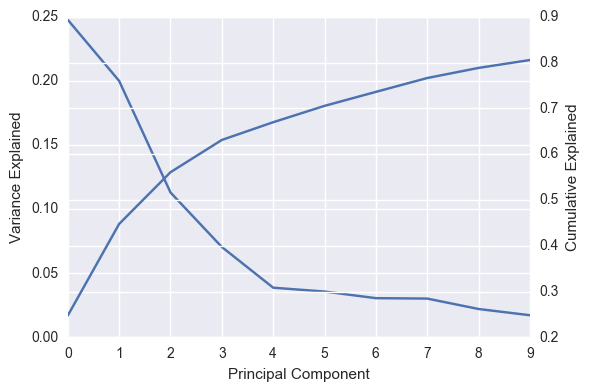

None

In [529]:
# Vectorize text
toxic_comments = raw_comments#[train['is_toxic']]

toxic_vect = vectorize_text(
    toxic_comments, 
    kind='count',
    output='df',
    param_dict=dict(
        ngram_range=(1,1),
        stop_words='english',
        max_features=100,
        binary=False
    )
)

display(skree_plot(data=toxic_vect, n_components=10))

In [530]:
pca = PCA(n_components=7)
pca.fit(toxic_vect)
toxic_components = pd.DataFrame(
    pca.transform(toxic_vect), 
    index=toxic_comments.index)

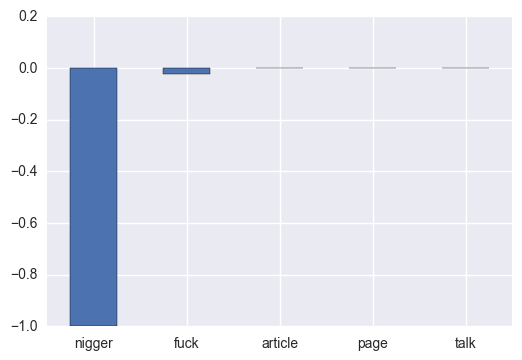

In [531]:
plot_pca(data=toxic_vect, component=1, n_features=5)

In [535]:
def get_poles_idx(data=toxic_components, component=1, percentile=0.5, pole='high'):
    if pole == 'high':
        return data.index[data.iloc[:, component - 1] < np.percentile(data.iloc[:, component - 1], q=percentile)]
    elif pole == 'low':
        return data.index[data.iloc[:, component - 1] < np.percentile(data.iloc[:, component - 1], q=1 - percentile)]
    
train.loc[get_poles_idx(toxic_components, component=1, percentile=0.95, pole='high')]

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,is_toxic,n_toxic
id,,,,,,,,,
2414065368,"""\nok a direct quote from the page for fuck is...",1,0,1,0,0,0,True,2
2461908386,"""\n\nHi Malik, Standing up to racism and bully...",0,0,0,0,0,0,False,0
3456115104,"is the sock puppet of ,fuck off",1,0,1,0,1,0,True,3
4651969382,alex fuck you \n\n...,1,0,1,0,1,0,True,3
5200557846,theres these 2 at fuck in school bathroom and ...,1,0,1,0,0,0,True,2
5285933881,WikiTheClown\nWelcome to Wikipedia. Although e...,1,0,1,0,1,0,True,3
6635257656,hey you dumb bitch if i cant spell saturn girl...,1,0,1,0,1,0,True,3
9111992246,fuck \n\n62.158.73.165 62.158.73.165 62.158...,1,1,1,0,1,0,True,4
12066822466,Why don't you go F yourself deliting nigger? F...,1,0,1,0,1,0,True,3


In [ ]:
cloud = WordCloud()
high_pc1 = 